#**NOTEBOOK IMPORTS**

In [28]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

# **LOAD DATA**

In [2]:
path = '/content/drive/MyDrive/Data'
os.listdir(path)

['training', 'validation']

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-07-20 14:11:07--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  25.6MB/s    in 3.3s    

2023-07-20 14:11:10 (25.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (256, 256, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [5]:
TRAINING_DIR = '/content/drive/MyDrive/Data/training'
VALIDATION_DIR = '/content/drive/MyDrive/Data/validation'

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [8]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 768)


#**DEFINING CALLBACK**

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    # Check loss
    if(logs.get('val_accuracy') >= 0.98):

      # Stop if threshold is met
      print("Validation Accuaracy is 90%.....So cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [10]:
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(4, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
# Set the training parameters
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [12]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1)

# **PREPARE THE IMAGE GENERATOR**

In [13]:
%%time

training_datagen = ImageDataGenerator(
    rescale = 1./255)
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=128
)


validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=30)

Found 4806 images belonging to 4 classes.
Found 1910 images belonging to 4 classes.
CPU times: user 472 ms, sys: 29.1 ms, total: 501 ms
Wall time: 13.7 s


#**Train the model**

In [14]:
%%time

# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 25,
            epochs = 15,
            validation_steps = 64,
            verbose = 1,
            callbacks=[callbacks])

Epoch 1/15
25/25 [==============================] - 2352s 95s/step - loss: 9.0773 - accuracy: 0.6544 - val_loss: 0.9327 - val_accuracy: 0.8461
Epoch 2/15
25/25 [==============================] - 444s 18s/step - loss: 0.3915 - accuracy: 0.9090 - val_loss: 0.2037 - val_accuracy: 0.9429
Epoch 3/15
25/25 [==============================] - 151s 6s/step - loss: 0.1068 - accuracy: 0.9669 - val_loss: 0.1159 - val_accuracy: 0.9613
Epoch 4/15
25/25 [==============================] - 66s 3s/step - loss: 0.0433 - accuracy: 0.9879 - val_loss: 0.1205 - val_accuracy: 0.9592
Epoch 5/15
25/25 [==============================] - 35s 1s/step - loss: 0.0232 - accuracy: 0.9925 - val_loss: 0.1079 - val_accuracy: 0.9644
Epoch 6/15
25/25 [==============================] - 26s 1s/step - loss: 0.0127 - accuracy: 0.9962 - val_loss: 0.1250 - val_accuracy: 0.9545
Epoch 7/15
25/25 [==============================] - 24s 962ms/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.1033 - val_accuracy: 0.9654
Epoch 8/15


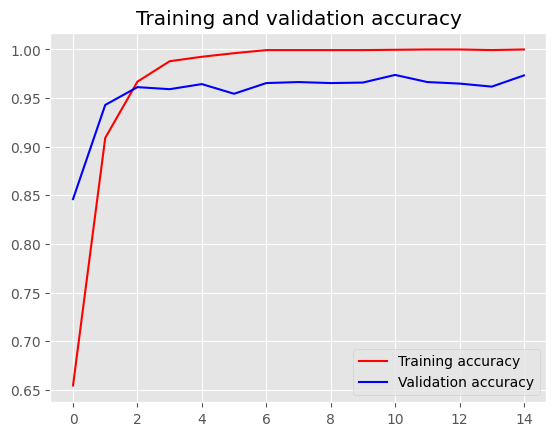

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

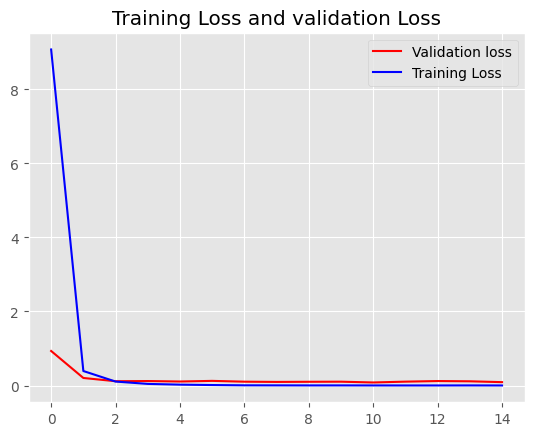

<Figure size 640x480 with 0 Axes>

In [20]:
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

# **MODEL EVALUATION**

In [30]:
# Get predictions for the validation set
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the loss and accuracy
loss = history.history['loss'][-1]
accuracy = history.history['accuracy'][-1]

# Calculate the precision, recall, false positive, and false negative
conf_matrix = confusion_matrix(y_true, y_pred)
false_positive = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
false_negative = conf_matrix.sum(axis=1) - np.diag(conf_matrix)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("False Positive:", false_positive)
print("False Negative:", false_negative)
print("Confusion Matrix:")
print(conf_matrix)

64/64 [==============================] - 8s 129ms/step
Loss: 0.0008349245763383806
Accuracy: 1.0
False Positive: [378 239 371 371]
False Negative: [376 274 361 348]
Confusion Matrix:
[[179  82 152 142]
 [ 87  65  97  90]
 [135  87 140 139]
 [156  70 122 167]]


# **VISUALISE THE CONFUSION MATRIX**

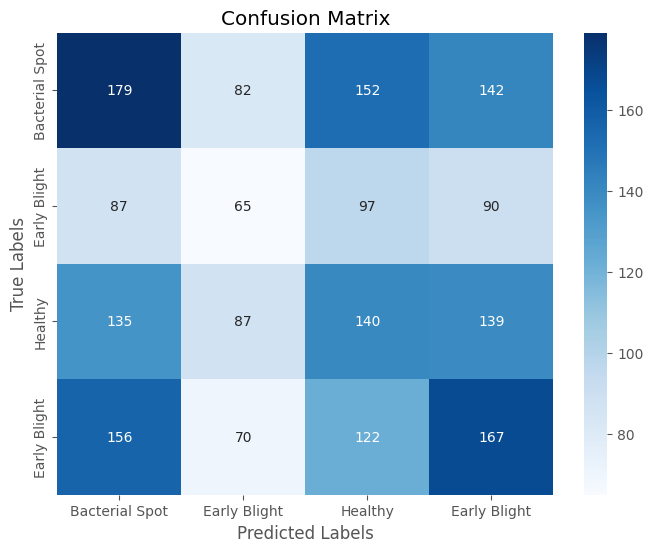

In [31]:
class_labels = ['Bacterial Spot', 'Early Blight', 'Healthy', 'Early Blight']

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

#**SAVE MODEL**

In [17]:
model.save('DenseNet.h5')

In [18]:
from google.colab import files
files.download('/content/DenseNet.h5')